# <center> Kaggle: HuBMAP + HPA - Hacking the Human Body </center>

The goal of this competition is to identify the locations of each functional tissue unit (FTU) in biopsy slides from several different organs. The underlying data includes imagery from different sources prepared with different protocols at a variety of resolutions, reflecting typical challenges for working with medical data.

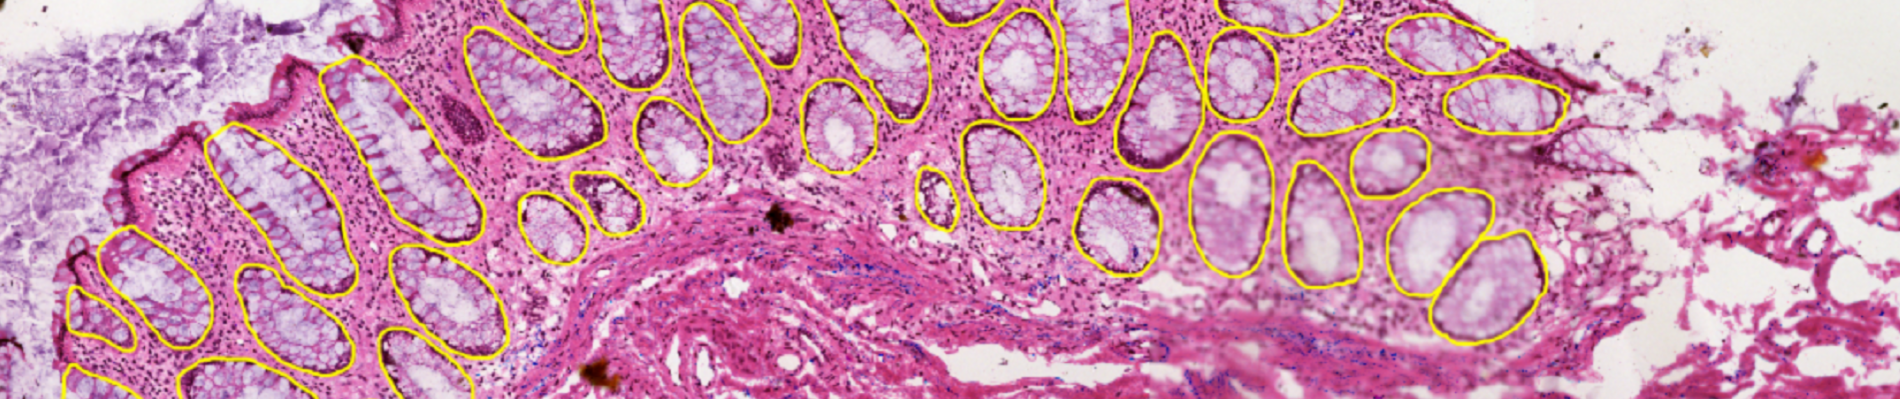

<p id="table"></p>

<br><br>

<h1 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; color: #BF2C58; background-color: #ffffff;">TABLE OF CONTENTS</h1>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"><a href="#imports">1&nbsp;&nbsp;&nbsp;&nbsp;INSTALLS & IMPORTS</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"><a href="#RLE">2&nbsp;&nbsp;&nbsp;&nbsp;RLE CONVERTORS AND PLOTTING</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"><a href="#EDA">3&nbsp;&nbsp;&nbsp;&nbsp;EDA</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"><a href="#dataset">4&nbsp;&nbsp;&nbsp;&nbsp;DATASET</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"><a href="#dataset_entry">5&nbsp;&nbsp;&nbsp;&nbsp;DATASET ENTRYPOINT</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"><a href="#model">6&nbsp;&nbsp;&nbsp;&nbsp;MODEL</a></h3>

---

<a id="imports"></a>
<h1 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #ffffff; color: #BF2C58;" id="imports">1&nbsp;&nbsp;INSTALLS & IMPORTS&nbsp;&nbsp;&nbsp;&nbsp;<a href="#table">&#10514;</a></h1>

In [1]:
!pip install nptyping

In [2]:
import math
import os
import shutil
import warnings
from typing import Callable, Optional, Tuple, Union

import albumentations as A
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import tifffile as tiff
import torch
from nptyping import NDArray, Float64, UInt8, Shape
from sklearn.model_selection import train_test_split
from torch.nn import Module
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

sns.set_style("darkgrid")
warnings.filterwarnings('ignore')

%matplotlib inline

<a id="RLE"></a>
<h1 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #ffffff; color: #BF2C58;" id="rle">2&nbsp;&nbsp;RLE CONVERTORS AND PLOTTING&nbsp;&nbsp;&nbsp;&nbsp;<a href="#table">&#10514;</a></h1>

In [3]:
def mask2rle(img: NDArray[Shape['*, *'], UInt8]) -> str:
    """
    Parameters
    ----------
    img : NDArray[Shape['*, *'], UInt8]
        Binary image mask.
    Returns
    -------
    str
        Running length encoded string.
    """
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle2mask(mask_rle: str, shape: Tuple[int, int]) -> NDArray[Shape['*, *'], UInt8]:
    """
    Parameters
    ----------
    mask_rle : str
        String representation of running length encoded.
    shape : Tuple[int, int]
        Size of the image in the (height, width) format.
    Returns
    -------
    NDArray[Shape['*, *'], UInt8]
        Binary mask with shape according to the {shape} variable.
    """
    mask_str = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (mask_str[0:][::2], mask_str[1:][::2])]
    ends = lengths + starts
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for low, high in zip(starts, ends):
        img[low:high] = 1
    return img.reshape(shape).T


def show_image_from_dataset(img_id: int,
                            df: pd.DataFrame,
                            path: str = '../input/hubmap-organ-segmentation/train_images/',
                            is_title: Optional[str] = None,
                            figsize: Tuple[int, int] = (10, 5)) -> matplotlib.figure.Figure:
    """
    Parameters
    ----------
    img_id : int
        Image id from the ['id'] column.
    df : pd.DataFrame
        Dataframe, containing image ['id'] and ['rle'] columns.
    path : str
        Path to the image folder.
    is_title : Optional[str]
        Make title for the plotted image.
    figsize : Tuple[int, int]
        Shape of the output image in the (width, height) format.
    Returns
    -------
    matplotlib.figure.Figure
        Plotting the image.
    """
    img = tiff.imread(path + str(img_id) + ".tiff")
    height, width = img.shape[0], img.shape[1]
    mask = rle2mask(df[df["id"] == img_id]["rle"].iloc[-1], (height, width))
    plt.figure(figsize=(10, 8));
    plt.imshow(img, zorder=1);
    plt.imshow(mask, cmap='coolwarm', alpha=0.5, zorder=1);
    if is_title:
        plt.title(is_title, fontsize=15, pad=20)
    

def show_image_with_mask(img:  NDArray[Shape['*, *, 3'], Float64],
                         mask:  NDArray[Shape['*, *'], UInt8]) -> matplotlib.figure.Figure:
    """
    Parameters
    ----------
    img : NDArray[Shape['*, *, *'], Float64]
        Image as a n-dimensional numpy array.
    mask : NDArray[Shape['*, *'], UInt8]
        Binary mask as a n-dimensional numpy array.
    Returns
    -------
    matplotlib.figure.Figure
        Plotting the image with its mask.
    """
    plt.figure(figsize=(10, 8));
    plt.imshow(img, zorder=1);
    plt.imshow(mask, cmap='coolwarm', alpha=0.5, zorder=1);

<a id="EDA"></a>
<h1 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #ffffff; color: #BF2C58;" id="eda">3&nbsp;&nbsp;EDA&nbsp;&nbsp;&nbsp;&nbsp;<a href="#table">&#10514;</a></h1>

In [4]:
train_df = pd.read_csv('../input/hubmap-organ-segmentation/train.csv')
test_df = pd.read_csv('../input/hubmap-organ-segmentation/test.csv')

In [5]:
train_df.head()

Dataset description:
- *id* - The image ID.
- *organ* - The organ that the biopsy sample was taken from.
- *data_source* - Whether the image was provided by Hubamp or HPA.
- *img_height* - The height of the image in pixels.
- *img_width* - The width of the image in pixels.
- *pixel_size* - The height/width of a single pixel from this image in micrometers.<br> All HPA images have a pixel size of 0.4 µm. For Hubmap imagery the pixel size is:<br>
    - 0.5 µm for kidney
    - 0.2290 µm for large intestine
    - 0.7562 µm for lung
    - 0.4945 µm for spleen
    - 6.263 µm for prostate.
- *tissue_thickness* - The thickness of the biopsy sample in micrometers.<br> All HPA images have a thickness of 4 µm. The Hubmap samples have tissue slice thicknesses:
    - 10 µm for kidney
    - 8 µm for large intestine
    - 4 µm for spleen
    - 5 µm for lung
    - and 5 µm for prostate.
- *rle* - The target column. A run length encoded copy of the annotations. **Provided for the training set only.**
- *age* - The patient's age in years. **Provided for the training set only.**
- *sex* - The sex of the patient. **Provided for the training set only.**

Lets have a closer look at the image with its segmented tissues

In [6]:
show_image_from_dataset(676, train_df)

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8));
sns.histplot(train_df['img_height'], bins=50, color='red', ax=ax[0]);
ax[0].set_xlabel('Image height in pixels', fontsize=16);
ax[0].set_ylabel('Number of images', fontsize=16);
ax[0].set_title('Histogram of the training set image resolutions', fontsize=16, pad=20);
sns.histplot(train_df['img_width'], bins=50, color='red', ax=ax[1]);
ax[1].set_xlabel('Image width in pixels', fontsize=16);
ax[1].set_ylabel('Number of images', fontsize=16);
ax[1].set_title('Histogram of the training set image width distribution', fontsize=16, pad=20);
fig.suptitle('Distribution of training set image shape characteristics', fontsize=18, y=1);

As it can be observerd, almost all images from the training set have 3000x3000 resolution, the floating range is [2308, 3070]. This have to be considered in choosing NN model architecture in general and type of transposed convolutions in particular.

In [8]:
plt.figure(figsize=(12,8));
sns.violinplot(data=train_df, x='sex', y='age', palette='viridis');
plt.xlabel('Sex', fontsize=15);
plt.xticks(fontsize=14);
plt.ylabel('Age', fontsize=15);
plt.yticks(np.arange(10, 101, 5), fontsize=13);
plt.title('Representation of patients ages divided by their sex', fontsize=16, pad=20);
print('Max female age:\t {}'.format(train_df[train_df['sex'] == 'Female']['age'].max()), end='\t')
print('Min female age:\t {}'.format(train_df[train_df['sex'] == 'Female']['age'].min()))
print('Max male age:\t {}'.format(train_df[train_df['sex'] == 'Male']['age'].max()), end='\t')
print('Min male age:\t {}'.format(train_df[train_df['sex'] == 'Male']['age'].min()))

Distributions of age groups are very close one to each other except the higher amount of male patients between 55 and 60 years old. <br>
Further investigations are needed to say whether this feature is important or not.

Now, let's observe the distribution of the samples across differernt organs.

In [9]:
plt.figure(figsize=(12,8));
sns.countplot(data=train_df,
              x='organ',
              orient='v',
              palette='viridis',
              order=train_df['organ'].value_counts(ascending=True).index);
plt.title('Biopsy samples distribution across different organs', fontsize=16, pad=20);
plt.xticks(fontsize=13);
plt.xlabel('Organ', fontsize=14);
plt.yticks(np.arange(0, 101, 5), fontsize=13);
plt.ylabel('Number of samples', fontsize=14);

Imballance can be observed here. The most common class (kidney) has 2 times more training samples than the rarest one (lung). In contrast to this, spleen and largeintestine classes have approximately the same number of data points.

Let's have a look not only on the amount of training data but also on the varition among segmented areas grouped by classes. To achieve it, it is needed to create a pivot table.

In [10]:
def pixel_precentage_counter(row: pd.Series) -> float:
    """
    Parameters
    ----------
    row : pd.Series
        Row from the training dataframe.
    Returns
    -------
    float
        How many precents of the image is covered by segmented area.
    """
    img_height = row['img_height']
    img_width = row['img_width']
    rle = row['rle'].split()
    pixel_amount = 0
    for index, value in enumerate(rle):
        if index % 2 != 0:
            pixel_amount += int(value)
    return 100 * pixel_amount / (img_height * img_width)


train_df['segments_average'] = train_df.apply(pixel_precentage_counter, axis=1)

segments_precentage_pivot = pd.pivot_table(train_df,
                                           index=['organ'],
                                           values=['segments_average', 'age'],
                                           aggfunc={'segments_average': np.mean,
                                                    'age': 'count'}).reset_index()
segments_precentage_pivot.columns = ['organ', 'items_count', 'segments_average']
segments_precentage_pivot = segments_precentage_pivot.sort_values(by='segments_average')
segments_precentage_pivot

In [11]:
fig = go.Figure(data=[go.Scatter(
    x=segments_precentage_pivot['organ'].values,
    y=segments_precentage_pivot['items_count'].values,
    text=['organ: lung<br>samples: 48<br>avg segments area: 2.08%',
          'organ: kidney<br>samples: 99<br>avg segments area: 3.02%',
          'organ: spleen<br>samples: 53<br>avg segments area: 10.1%',
          'organ: prostate<br>samples: 93<br>avg segments area: 15.4%',
          'organ: largeintestine<br>samples: 58<br>avg segments area: 19.34%'],
    mode='markers',
    marker=dict(
        colorscale='magma',
        color=segments_precentage_pivot['segments_average'].values,
        size=segments_precentage_pivot['segments_average'].values * 10,
        colorbar=dict(title="Area, %"),
        showscale=True))])

fig.update_layout(
    title="Bubble plot representing average segmented area precentage according to different organs",
    xaxis_title="Organs",
    yaxis_title="Amount of samples")

fig.show()

Lung and kidney organs have 2.08% and 3.02% of average segmented areas respectively. The most significant segmentation coverage is in the largeintestine class - 19.34% in average. Keeping this in mind, it is important to analyse pictures itself (e.g. using show_image_with_mask function) and, if the majority of organs will have various segment shapes, than, probably smart choice is to train not one but a couple of neural networks. Each of them will have to segment functional tissues in its particular organ or set of organs.

<a id="dataset"></a>
<h1 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #ffffff; color: #BF2C58;" id="dataset">4&nbsp;&nbsp;DATASET&nbsp;&nbsp;&nbsp;&nbsp;<a href="#table">&#10514;</a></h1>

In [13]:
class SegmentationDataset(Dataset):
    def __init__(self,
                 df: pd.DataFrame,
                 img_path: str,
                 transform: Optional[A.Compose] = None,
                 is_train: bool = True,
                 is_valid: bool = False,
                 device: str = 'cuda'):
        self.df = df
        self.img_path = img_path
        self.transform = transform
        self.is_train = is_train
        self.is_valid = is_valid
        self.device = device 
    
    def __len__(self) -> int:
        return len(self.df)
        
    
    def __getitem__(self, idx: int) -> Union[Tuple[torch.Tensor, torch.Tensor],
                                             Tuple[torch.Tensor]]:
        row = self.df.iloc[idx]
        img_id = row['id']
        img = tiff.imread(self.img_path + str(img_id) + ".tiff")
        if self.is_train or self.is_valid:
            rle = row['rle']
            mask = rle2mask(rle, (img.shape[1], img.shape[0]))
            if self.transform:
                transformed = self.transform(image=img, mask=mask)
                img = transformed['image']
                mask = transformed['mask']
                img = torch.Tensor(img).to(self.device)
                mask = torch.Tensor(mask).to(self.device)
            return img, mask
        else:
            if self.transform:
                transformed = self.transform(image=img)
                img = transformed['image']
                img = torch.Tensor(img).to(self.device)
            return img

In [17]:
def image_cropper(img: Union[NDArray[Shape['*, *, 3'], Float64], NDArray[Shape['*, *'], UInt8]],
                  height_min_border: int,
                  height_max_border: Union[int, None],
                  width_min_border: int,
                  width_max_border: Union[int, None]) -> Union[NDArray[Shape['*, *, 3'], Float64],
                                                               NDArray[Shape['*, *'], UInt8]]:
    """
    Parameters
    ----------
    img: np.ndarray
        Image that will be cropped.
    height_max_border : Union[int, None]
        Y-axis max border for image croppping.
    height_min_border : int
        Y-axis min border for image croppping.
    width_max_border : Union[int, None]
        X-axis max border for image croppping.
    width_min_border : int
        X-axis min border for image croppping.
    Returns
    -------
    Union[NDArray[Shape['*, *, 3'], Float64], NDArray[Shape['*, *'], UInt8]]
        Cropped image/mask according to defined parameters.
    """
    sub_img = img[height_min_border:height_max_border,
                  width_min_border:width_max_border]
    return sub_img


def segmentation_decomposition(path_to_save: str,
                               df_to_initial_data: pd.DataFrame,
                               img_column_name: str,
                               img_column_type: Callable,
                               rle_mask_column_name: str,
                               path_to_initial_data: str = '../input/hubmap-organ-segmentation/train_images/',
                               is_train: bool = True,
                               units: int = 4) -> pd.DataFrame:
    """
    Parameters
    ----------
    path_to_save : str
        Path for storing new dataset.
    df_to_initial_data : pd.DataFrame
        Dataframe, containing image filename and mask decoded running length.
    path_to_initial_data: str
        Path where original dataset is located.
    is_train : bool
        Defines whether new dataset id train or not. For train dataset
        there is addditional creation of rle from binary mask.
    units : int
        The number of subimages from the original image.
    Returns
    -------
    pd.DataFrame
        Create a new dataset in '{path_to_save}' folder
        with '{unit}' times more data points that was originally.
        Creates and return new dataframe, containing renewed filenames
        and running length encoded masks.
    """
    new_data = pd.DataFrame(columns=[['id', 'rle']])
    for file in tqdm(sorted(os.listdir(path_to_initial_data))):
        file_without_extension = img_column_type(file.split('.')[0])
        df_sample = df_to_initial_data[df_to_initial_data[img_column_name] == file_without_extension]
        img = tiff.imread(path_to_initial_data + file)
        if is_train:
            mask_rle = df_sample[rle_mask_column_name].values[0]
            mask = rle2mask(mask_rle, (img.shape[0], img.shape[1]))
        blocks_segment = int(math.sqrt(units))
        height_step = img.shape[0] // blocks_segment
        width_step = img.shape[1] // blocks_segment
        index_counter = 1
        for unit_height in range(blocks_segment):
            for unit_width in range(blocks_segment):
                parameters_to_save = []
                new_filename = str(file_without_extension) + f'_{index_counter}'
                parameters_to_save.append(new_filename)
                
                height_min_border = height_step * unit_height
                height_max_border = height_step * (unit_height + 1)
                width_min_border = width_step * unit_width
                width_max_border = width_step * (unit_width + 1)
                
                if unit_width == unit_height == blocks_segment - 1:
                    height_max_border = None
                    width_max_border = None
                    sub_img = image_cropper(img, height_min_border, height_max_border, width_min_border, width_max_border)
                    
                elif unit_width == blocks_segment - 1:
                    width_max_border = None
                    sub_img = image_cropper(img, height_min_border, height_max_border, width_min_border, width_max_border)
                    
                elif unit_height == blocks_segment - 1:
                    height_max_border = None
                    sub_img = image_cropper(img, height_min_border, height_max_border, width_min_border, width_max_border)
                
                else:
                    sub_img = image_cropper(img, height_min_border, height_max_border, width_min_border, width_max_border)
            
                if is_train:
                    sub_mask = image_cropper(mask, height_min_border, height_max_border, width_min_border, width_max_border)
                    sub_mask_rle = mask2rle(sub_mask)
                    parameters_to_save.append(sub_mask_rle)
                
                tiff.imsave(path_to_save + new_filename + '.tiff', sub_img)
                new_data.loc[len(new_data)] = parameters_to_save
                index_counter += 1
    return new_data

In [18]:
def make_dataloader(df: pd.DataFrame,
                    size: int,
                    path: str,
                    batch_size: int,
                    is_train: bool = True,
                    is_valid: bool = False,
                    is_decomposition: bool = True,
                    device: str = 'cuda') -> DataLoader:
    """
    Parameters
    ----------
    df : pd.DataFrame
        Dataframe with image ids for training.
    size : int
        Image resize size (both width and height).
    path : str
        Path to the image folder.
    batch_size : int
        The number of images in training loader batch.
    is_train : bool
        Defines whether this a training set or not.
    device : str
        Device to perform computation on (either 'cuda' or 'cpu').
    Returns
    -------
    DataLoader
        Train DataLoader with images and their masks.
    """
    train_transform = A.Compose(
        [
            A.Resize(size, size),
            A.HorizontalFlip(p=0.5) if not is_decomposition else None,
            A.VerticalFlip(p=0.5) if not is_decomposition else None,
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ]
    )
    
    test_transform = A.Compose(
        [
            A.Resize(size, size),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ]
    )
    
    dataset = SegmentationDataset(df=df,
                                  img_path=path,
                                  transform=train_transform if (is_train or is_valid) else test_transform,
                                  is_train=is_train,
                                  is_valid=is_valid,
                                  device=device)
    
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=True if is_train else False,
                            drop_last=True if is_valid else False)
    return dataloader


def make_validation(df: pd.DataFrame,
                    test_size: float = 0.1) -> Tuple[pd.DataFrame,
                                                     pd.DataFrame]:
    """
    Parameters
    ----------
    df : pd.DataFrame
        Dataframe to split.
    test_size : float
        The precentage of validation part after
        the dataset splitted. Ranges between 0 and 1.
    Returns
    -------
    DataLoader
        Train DataLoader with images and their masks.
    """
    train, test = train_test_split(df,
                                   test_size=test_size,
                                   random_state=RANDOM_STATE)
    return train, test

<a id="dataset_entry"></a>
<h1 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #ffffff; color: #BF2C58;" id="dataset_entry">5&nbsp;&nbsp;DATASET ENTRYPOINT&nbsp;&nbsp;&nbsp;&nbsp;<a href="#table">&#10514;</a></h1>

In [19]:
NEW_PATH = '../working/new_data_folder/'
ORIGINAL_PATH = '../input/hubmap-organ-segmentation/train_images/'
UNITS = 4
TRANSFORMS = True
RESIZE = 560
IS_DECOMPOSITION = True
BS = 4
RANDOM_STATE = 42
DEVICE = 'cuda'


def dataset_entry(train_df: pd.DataFrame,
                  valid_size: Optional[float] = None,
                  add_valid: bool = False) -> Union[DataLoader,
                                                    Tuple[DataLoader, DataLoader]]:
    """
    Parameters
    ----------
    train_df : pd.DataFrame
        Train dataframe to make dataloader from.
    valid_size : Optional[float]
        The amount of valid size in th dataset. Ranges from 0 to 1.
    add_valid : bool
        Parameter to regulate whether to add validation or not
    Returns
    -------
    float
        How many precents of the image is covered by segmented area.
    """
    if IS_DECOMPOSITION:
        !rm -rf $NEW_PATH
        !mkdir $NEW_PATH
        train_df = segmentation_decomposition(path_to_save=NEW_PATH,
                                              df_to_initial_data=train_df,
                                              img_column_name='id',
                                              img_column_type=int,
                                              rle_mask_column_name='rle',
                                              path_to_initial_data=ORIGINAL_PATH,
                                              is_train=True,
                                              units=UNITS)
        
    path = ORIGINAL_PATH if not IS_DECOMPOSITION else NEW_PATH
    
    if add_valid:
        train_df, valid_df = make_validation(train_df, valid_size)
        valid_dataloader = make_dataloader(df=valid_df,
                                           size=RESIZE,
                                           path=path,
                                           batch_size=BS,
                                           is_train=False,
                                           is_valid=True,
                                           is_decomposition=IS_DECOMPOSITION,
                                           device=DEVICE)
    
    train_dataloader = make_dataloader(df=train_df,
                                       size=RESIZE,
                                       path=path,
                                       batch_size=BS,
                                       is_train=True,
                                       is_valid=False,
                                       is_decomposition=IS_DECOMPOSITION,
                                       device=DEVICE)

    return train_dataloader, valid_dataloader if add_valid else None


train_dataloader, valid_dataloader = dataset_entry(train_df=train_df, valid_size=0.2, add_valid=True)